In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2

## Load iRefIndex Raw Data
**Source (MITAB):**  http://irefindex.org/download/irefindex/data/archive/release_14.0/psi_mitab/MITAB2.6/9606.mitab.07042015.txt.zip  
Downloaded: November 16, 2021 
Last Updated: June 11, 2021  
Notes for processing: This is the file for human protein interactions, however, not all interactions are human-human interactions. These need to be filtered. Also all ID's not without RefSeq or UniProt ID are excluded. Custom processing for this network is described below  
  
**From iRefIndex Mapping Documentation Page:**  
"We have made a file which provides mappings between iRefIndex identifiers and popular external identifiers. The current files contain all UniProt and RefSeq identifiers known to the current version of iRefIndex as documented on the sources page. For specific source documentation, see the sources for each released version.  
  
Other database identifiers are provided as database/accession pairs only when the iRefIndex identifier (ROGID) does not have a corresponding UniProt or RefSeq record with an identical sequence."  
  
Therefore: Interactions containing an ROGID identifier will be removed

In [4]:
input_raw_v2 = pd.read_csv(wd+'Network_Data_Raw/iRefIndex/9606.mitab.06-11-2021.txt.zip',sep='\t')
print('Raw edge count in iRefIndex:', len(input_raw_v2))

Raw edge count in iRefIndex: 3602589


In [5]:
# Keep only human-human interactions
input_human_v2 = input_raw_v2[(input_raw_v2['taxa']=='taxid:9606(Homo sapiens)') & (input_raw_v2['taxb']=='taxid:9606(Homo sapiens)')]
print('Human-Human only interactions in iRefIndex:', len(input_human_v2))

Human-Human only interactions in iRefIndex: 2179732


In [6]:
# Extract gene list
genes_v2 = list(set(input_human_v2['#uidA']).union(set(input_human_v2['uidB'])))

In [7]:
# Get all iRef prefixes
prefixes=[]
for gene in genes_v2:
    prefix=gene.split(':')[0]
    if prefix not in prefixes:
        prefixes.append(prefix)
print(prefixes)

['uniprotkb', 'rogid', 'refseq']


In [9]:
# Get edge list of network
edgelist_v2 = input_human_v2[['#uidA','uidB']].values.tolist()
print(len(edgelist_v2), "Human iRefIndex Edges")

2179732 Human iRefIndex Edges


## Convert Genes

In [10]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'rogid' prefix)
# This should only keep uniprotkb and refseq as queries
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2, exclude_prefixes=['rogid'])

31039 Valid Query Genes
918 Invalid Query Genes


In [11]:
# filter edgelist because len(invalid_genes) > 0
edgelist_filt_v2 = gct.filter_query_edgelist(edgelist_v2, invalid_genes_v2)

8571 / 2179732 edges with invalid nodes removed


## Isoforms to uniprot

In [16]:
uniprot_ids_v2, missing_v2 = gct.query_uniprot(valid_genes_v2, return_as_dict=False, target_fmt="ACC")

In [18]:
uniprot_mapping_v2 = pd.concat([uniprot_ids_v2, pd.DataFrame({"query":missing_v2, "ACC":missing_v2, "_score":0})])
uniprot_query_v2, valid_uniprot_v2, invalid_uniprot_v2 = gct.query_constructor(uniprot_mapping_v2["ACC"].tolist())

31040 Valid Query Genes
0 Invalid Query Genes


In [19]:
# Set scopes (gene naming systems to search)
scopes = "uniprot, refseq"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(uniprot_query_v2, scopes=scopes, fields=fields)
print(len(match_list_v2), 'Matched query results')

100%|██████████| 32/32 [00:27<00:00,  1.18it/s]

31342 Matched query results
Batch query complete: 27.21 seconds
31342 Matched query results


In [20]:
match_list_v2 = pd.DataFrame.from_dict(match_list_v2)

In [22]:
match_list_final_v2 = match_list_v2.merge(uniprot_mapping_v2, left_on = ["query"], right_on=["ACC"])
match_list_final_v2 = match_list_final_v2.loc[:, ("query_y", "_id", "_score_x", "symbol", "notfound")]
match_list_final_v2.columns = ["query", "entrezgene", "_score", "symbol", "notfound"]

In [23]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_final_v2, valid_genes_v2)

Number of genes with multiple matches: 12037
Number of unmatched genes: 3602
Number of fully matched genes: 27433
Number of partially matched genes: 3606


## Construct Converted Network

In [24]:
# Format edge list by removing prefix indicators from all interactors
edgelist_filt_v2 = [[gct.get_identifier_without_prefix(edge[0]),gct.get_identifier_without_prefix(edge[1])] for edge in edgelist_filt_v2]

In [28]:
# Convert network edge list to symbol
edgelist_updated_v2 = gct.convert_edgelist(edgelist_filt_v2, query_to_symbol_v2)

In [29]:
# Filter converted edge list
edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(edgelist_updated_v2)

2171161 input edges
46943 self-edges removed
193922 edges with un-mapped genes removed
1441807 duplicate edges removed
Edge list filtered: 0.86 seconds
488489 Edges remaining


In [15]:
# Save filtered, converted edge list to file
gct.write_edgelist(edgelist_symbol_filt_v2, wd+'rocessed_Data/Network_SIFs_SymbPol/iRefIndex_Symbol_2021.sif')

Edge list saved: 0.44 seconds


# Version 1 (Original)

## Load iRefIndex Raw Data
**Source (MITAB):**   http://irefindex.org/download/irefindex/data/archive/release_14.0/psi_mitab/MITAB2.6/9606.mitab.07042015.txt.zip  
Downloaded: July 28, 2016  
Last Updated: April 20, 2015  
Notes for processing: This is the file for human protein interactions, however, not all interactions are human-human interactions. These need to be filtered. Also all ID's not without RefSeq or UniProt ID are excluded. Custom processing for this network is described below  
  
**From iRefIndex Mapping Documentation Page:**  
"We have made a file which provides mappings between iRefIndex identifiers and popular external identifiers. The current files contain all UniProt and RefSeq identifiers known to the current version of iRefIndex as documented on the sources page. For specific source documentation, see the sources for each released version.  
  
Other database identifiers are provided as database/accession pairs only when the iRefIndex identifier (ROGID) does not have a corresponding UniProt or RefSeq record with an identical sequence."  
  
Therefore: Interactions containing an ROGID identifier will be removed

In [30]:
input_raw = pd.read_csv(wd+'Network_Data_Raw/iRefIndex/9606.mitab.04072015.txt',sep='\t')
print('Raw edge count in iRefIndex:', len(input_raw))

Raw edge count in iRefIndex: 673100


In [31]:
# Keep only human-human interactions
input_human = input_raw[(input_raw['taxa']=='taxid:9606(Homo sapiens)') & (input_raw['taxb']=='taxid:9606(Homo sapiens)')]
print('Human-Human only interactions in iRefIndex:', len(input_raw))

Human-Human only interactions in iRefIndex: 673100


In [32]:
# Extract gene list
genes = list(set(input_raw['#uidA']).union(set(input_raw['uidB'])))

In [35]:
# Get all iRef prefixes
prefixes=[]
for gene in genes:
    prefix=gene.split(':')[0]
    if prefix not in prefixes:
        prefixes.append(prefix)
print(prefixes)

['uniprotkb', 'refseq', 'complex', 'rogid']


In [36]:
# Get edge list of network
edgelist = input_human[['#uidA','uidB']].values.tolist()
print(len(edgelist), "Human iRefIndex Edges")

485030 Human iRefIndex Edges


## Convert Genes

In [37]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'rogid' prefix)
# This should only keep uniprotkb and refseq as queries
query_string, valid_genes, invalid_genes = gct.query_constructor(genes, exclude_prefixes=['rogid', 'complex'])

35525 Valid Query Genes
10104 Invalid Query Genes


In [39]:
# filter edgelist because len(invalid_genes) > 0
edgelist_filt = gct.filter_query_edgelist(edgelist, invalid_genes)

6305 / 485030 edges with invalid nodes removed


## Convert uniprot isoforms/outdated symbols

In [38]:
uniprot_ids, missing = gct.query_uniprot(valid_genes, return_as_dict=False, target_fmt="ACC")

In [40]:
uniprot_mapping = pd.concat([uniprot_ids, pd.DataFrame({"query":missing, "ACC":missing, "_score":0})])
uniprot_query, valid_uniprot, invalid_uniprot = gct.query_constructor(uniprot_mapping["ACC"].tolist())

35557 Valid Query Genes
0 Invalid Query Genes


In [41]:
uniprot_query, valid_uniprot, invalid_uniprot = gct.query_constructor(uniprot_mapping["ACC"].tolist())

35557 Valid Query Genes
0 Invalid Query Genes


In [42]:
# Set scopes (gene naming systems to search)
scopes = "uniprot, refseq"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(uniprot_query, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 36/36 [00:31<00:00,  1.13it/s]

36022 Matched query results
Batch query complete: 31.78 seconds
36022 Matched query results


In [43]:
match_list = pd.DataFrame.from_dict(match_list)

In [44]:
match_list_final = match_list_v2.merge(uniprot_mapping, left_on = ["query"], right_on=["ACC"])
match_list_final = match_list_final.loc[:, ("query_y", "_id", "_score_x", "symbol", "notfound")]
match_list_final.columns = ["query", "entrezgene", "_score", "symbol", "notfound"]

In [45]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Number of genes with multiple matches: 4397
Number of unmatched genes: 5316
Number of fully matched genes: 26280
Number of partially matched genes: 5345


## Construct Converted Network

In [46]:
# Format edge list by removing prefix indicators from all interactors
edgelist_filt= [[gct.get_identifier_without_prefix(edge[0]),gct.get_identifier_without_prefix(edge[1])] for edge in edgelist_filt]

In [47]:
# Convert network edge list to symbol
edgelist_updated = gct.convert_edgelist(edgelist_filt, query_to_symbol)

In [48]:
# Filter converted edge list
edgelist_symbol_filt = gct.filter_converted_edgelist(edgelist_updated)

478725 input edges
12075 self-edges removed
168750 edges with un-mapped genes removed
170142 duplicate edges removed
Edge list filtered: 0.16 seconds
127758 Edges remaining


In [27]:
# Filter converted edge list
edgelist_symbol_filt = gct.filter_converted_edgelist(edgelist_updated)

478725 input edges
12077 self-edges removed
168006 edges with un-mapped genes removed
166987 duplicate edges removed
Edge list filtered: 0.12 seconds
131655 Edges remaining


In [49]:
# Save filtered, converted edge list to file
gct.write_edgelist(edgelist_symbol_filt , wd+'Processed_Data/Network_SIFs_Symbol/iRefIndex_Symbol_2015.sif')

Edge list saved: 0.22 seconds


# Changes

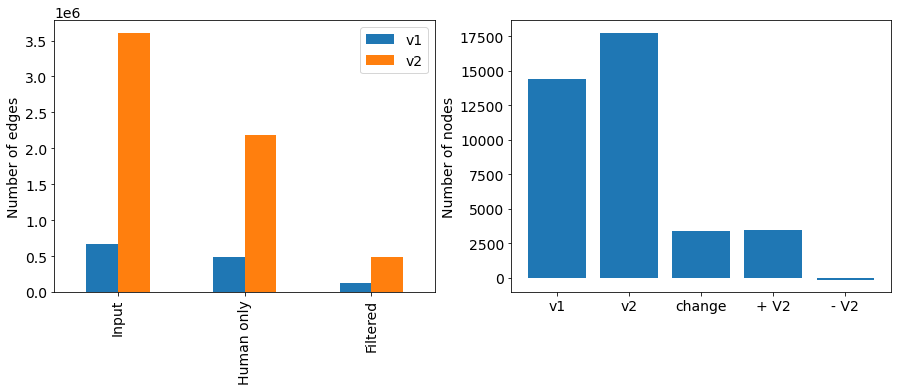

In [52]:
dit.plot_changes_to_dataset(input_raw, input_raw_v2, edgelist_symbol_filt, edgelist_symbol_filt_v2, input_human, input_human_v2)